In [26]:
#1)Regroup labels?
#2)Consider whether it would make sense to include meta-data features as well. If so, which ones, and why? 
#If relevant, report the performance when including these additional features and compare it to the first baselines. Discuss whether these results match your expectations.
#
#
#

In [27]:
%matplotlib inline
import re
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from collections import Counter
from cleantext import clean
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem import SnowballStemmer
from collections import Counter
import subprocess
import zipfile
import io
import csv
import zipfile38 as zipfile
from dask import dataframe as dd
from sklearn.model_selection import train_test_split
import h5py
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/simonmork/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [28]:
# Define settings for cleaning
def clean_text(text):
    """Calls the clean function from cleantext clean on a string"""
    t = clean(text,
    fix_unicode=False,               # fix various unicode errors
    to_ascii=True,                  # transliterate to closest ASCII representation
    lower=True,                     # lowercase text
    no_line_breaks=True,         # fully strip line breaks as opposed to only normalizing them NOT WORKING?
    no_urls=True,                  # replace all URLs with a special token
    no_emails=True,                # replace all email addresses with a special token
    no_phone_numbers=False,         # replace all phone numbers with a special token
    no_numbers=True,               # replace all numbers with a special token
    no_digits=False,                # replace all digits with a special token
    no_currency_symbols=False,      # replace all currency symbols with a special token
    no_punct=True,                 # remove punctuations
    replace_with_punct="",          # instead of removing punctuations you may replace them
    replace_with_url="URL",
    replace_with_email="EMAIL",
    replace_with_phone_number="PHONE",
    replace_with_number="NUM",
    replace_with_digit="0",
    replace_with_currency_symbol="CUR",
    lang="en"                       # set to 'de' for German special handling
    )
    return t


pd.set_option("display.max_colwidth", 10000000)    
print("Done")    
    


Done


In [29]:
#Small df
print("Getting csv...")
df = pd.read_csv('https://raw.githubusercontent.com/several27/FakeNewsCorpus/master/news_sample.csv')
print(type(df))

Getting csv...
<class 'pandas.core.frame.DataFrame'>


In [30]:
csv_textfilereader = pd.read_csv(r'/Users/simonmork/Desktop/GitHub/FinalProjectDS/news_cleaned_2018_02_13.csv', chunksize=1000000, iterator=True)

first_chunk = csv_textfilereader.get_chunk(10000)
first_article = first_chunk.iloc[1]
print("len: ", len(first_chunk))
print( first_article)

len:  10000
Unnamed: 0                                                                                                                                                                                                                                                                                                                                                                         1
id                                                                                                                                                                                                                                                                                                                                                                                 6
domain                                                                                                                                                                                                                                            

In [31]:
    # Clean dataframe function
def clean_df(df):
        print("Getting headers..")
        column_names = list(df.columns.values)
        #print(column_names)

        print("Cleaning...")
        for index, row in df.iterrows():
            #print(df.at[index,'content'])
            cleaned = clean_text(row['content'])
            df.at[index,'content'] = cleaned
            #print(cleaned)
            
            
        # Split the content column into a list of words
        words = df['content'].str.split()
        # Create a set of unique words
        unique_words = set(word for word_list in words for word in word_list)
        # Count the number of unique words
        num_unique_words_after_clean = len(unique_words)
        print(num_unique_words_after_clean) 



        print("Tokenizing and removing stopwords...")
        stop_words = set(stopwords.words('english'))
        for index, row in df.iterrows():    
            #print(df.at[index,'content'])
            df.at[index,'content'] = nltk.word_tokenize(row['content'])
            
            filtered_sentence = []
            for w in df.at[index,'content']:
                if w not in stop_words:
                    filtered_sentence.append(w)
            
            df.at[index,'content'] = filtered_sentence
            #print(filtered_sentence)
        

        # concatenate all the lists into a single list of words
        words = [word for content in df['content'] for word in content]
        # get the set of unique words
        unique_words = set(words)
        # get the number of unique words
        num_unique_words_after_stop = len(unique_words)
        print(num_unique_words_after_stop)
        print(1-num_unique_words_after_stop/num_unique_words_after_clean)
            
            

        print("Stemming")
        snowball = SnowballStemmer(language='english')
        for index, row in df.iterrows():   
            stemmed = []
            for word in df.at[index,'content']:
                stemmed.append(snowball.stem(word))
            df.at[index,'content'] = stemmed
            #print(stemmed)


        # concatenate all the lists into a single list of words
        words = [word for content in df['content'] for word in content]
        # get the set of unique words
        unique_words = set(words)
        # get the number of unique words
        num_unique_words_after_stem = len(unique_words)
        print(num_unique_words_after_stem)
        print(1-num_unique_words_after_stem/num_unique_words_after_stop)

        print("Done...")
        return df, unique_words
        


In [32]:
df, unique_words = clean_df(first_chunk)


Getting headers..
Cleaning...
114693
Tokenizing and removing stopwords...
114294
0.0034788522403285116
Stemming
84173
0.2635396433758552
Done...


In [33]:
#Part 1 - Task 2
print("Counting number of urls, dates and num, and fake news and trump")
url = 0
num = 0
trump=0
fakenews = 0
notfake = 0
for index, row in df.iterrows():
    for word in df.at[index,'content']:
        #print(word)
        if word == 'url':
            url = url+1
        if word == 'num':
            num = num+1
        if word == 'trump':
            trump = trump+1
    if df.at[index,'type'] == 'fake':
        fakenews = fakenews+1
    else:
        notfake = notfake+1
print("Num urls: ", url)
print("Num num: ", num)
print("Num trump: ", trump)
print("Num fake: ", fakenews)
print("Num notfake: ", notfake)

Counting number of urls, dates and num, and fake news and trump
Num urls:  6148
Num num:  96551
Num trump:  15289
Num fake:  3663
Num notfake:  6337


##### This code splits a DataFrame df into training, validation, and testing sets, with a 80:10:10 ratio. The X variable contains the content of the articles, while the y variable contains the type of the articles (reliable/fake).

In [34]:
X, y = df.content, df['type']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size = 0.2, random_state = 0)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size = 0.5, random_state = 0)


#### make_bin function to convert categorical data into binary labels
##### make_bin is a function that takes in a list of categorical data and converts it into a list of binary labels. The function iterates through the input list and assigns a binary label of 0 to each non-'fake' element and a label of 1 to each 'fake' element. The resulting binary labels are returned as a list, which can be used as target values for machine learning algorithms.

In [35]:
def make_bin(to_bin):
    to_bin = np.asarray(to_bin)
    reliable = 0
    fake = 0
    bin_list = []
    for i in range(len(to_bin)):
        if to_bin[i] != 'fake':
            bin_list.append(0)
            reliable = reliable +1
        else:
            bin_list.append(1)
            fake = fake+1
    return bin_list

In [36]:
y_train_bin = make_bin(y_train)
y_val_bin = make_bin(y_val)
y_test_bin = make_bin(y_test)


#### X_vectoriser function to transform text data into a sparse matrix representation
##### X_vectoriser is a function that takes in a list of text data as input, concatenates the words in each string, and transforms the resulting text data into a sparse matrix representation using the CountVectorizer from scikit-learn. The resulting matrix can be used as input to machine learning algorithms.

In [37]:
def X_vectoriser(vectee):
    vectee = [' '.join(words) for words in vectee]
    vectorizer = CountVectorizer(vocabulary=unique_words)
    vectee = vectorizer.fit_transform(vectee)
    return vectee

In [38]:
X_train_vec = X_vectoriser(X_train)
X_val_vec = X_vectoriser(X_val)
X_test_vec = X_vectoriser(X_test)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:1322: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  warnings.warn(


### A simple logistic model:

In [39]:
simple_log_model = LogisticRegression(max_iter=100000)
simple_log_model.fit(X_train_vec, y_train_bin)
y_pred = simple_log_model.predict(X_val_vec)

acc_simple_log = accuracy_score(y_val_bin, y_pred)
print(accuracy_score(y_val_bin, y_pred))

0.952


### Alt nedenfor er rettet mod den komplicerede model

#### Gaussion model: (kan ikke køre med lige så meget data som den logistiske)


In [46]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from imblearn.under_sampling import RandomUnderSampler

# create a RandomUnderSampler instance
rus = RandomUnderSampler(random_state=0)

# fit and transform the training data using RandomUnderSampler
X_train_resampled, y_train_resampled = rus.fit_resample(X_train_vec.toarray(), y_train_bin)

# train the model on the resampled data
simple_nb_model = GaussianNB()
simple_nb_model.fit(X_train_resampled, y_train_resampled)

# make predictions on the validation data
y_pred2 = simple_nb_model.predict(X_val_vec.toarray())

# evaluate the accuracy of the model's predictions
acc_gaus = accuracy_score(y_val_bin, y_pred2)
print(accuracy_score(y_val_bin, y_pred2))


0.733


#### Logistisk model with confusion matrix and classification report:

Accuracy for C=0.1: 0.963
Best C: 0.1
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       636
           1       0.98      0.91      0.95       364

    accuracy                           0.96      1000
   macro avg       0.97      0.95      0.96      1000
weighted avg       0.96      0.96      0.96      1000



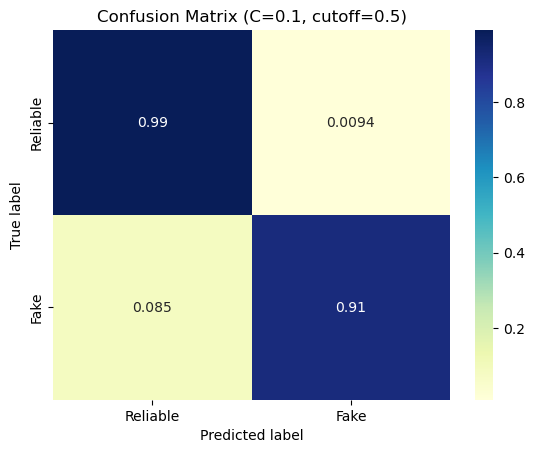

In [41]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import seaborn as sns

Cs = [0.1]
best_accuracy = 0
best_c = 0
best_y_pred = None

for c in Cs:
    simple_log_model = LogisticRegression(max_iter=100000, C=c, class_weight='balanced')
    simple_log_model.fit(X_train_vec, y_train_bin)
    y_pred = simple_log_model.predict(X_val_vec)
    accuracy = accuracy_score(y_val_bin, y_pred)
    print(f"Accuracy for C={c}: {accuracy}")
    
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_c = c
        best_y_pred = y_pred

print("Best C:", best_c)

# generate class probabilities and select cutoff
probas = simple_log_model.predict_proba(X_val_vec)
cutoff = 0.5
y_pred_cutoff = (probas[:,1] > cutoff).astype(int)

# print classification report
print(classification_report(y_val_bin, y_pred_cutoff))

# calculate and plot confusion matrix in percentages
conf_mat = confusion_matrix(y_val_bin, y_pred_cutoff, normalize='true')
sns.heatmap(conf_mat, annot=True, cmap="YlGnBu", xticklabels=['Reliable', 'Fake'], yticklabels=['Reliable', 'Fake'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title(f'Confusion Matrix (C={best_c}, cutoff={cutoff})')
plt.show()


<AxesSubplot:>

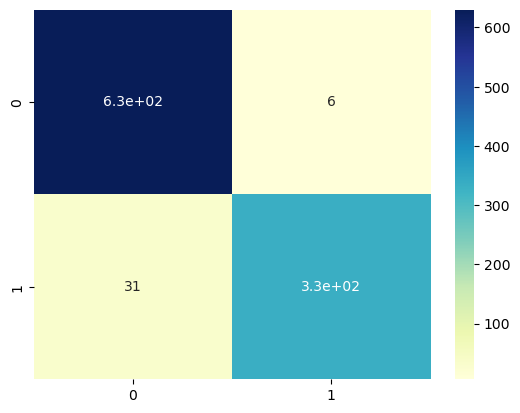

In [42]:
# calculate and plot confusion matrix with absolute values
conf_mat1 = confusion_matrix(y_val_bin, best_y_pred)
sns.heatmap(conf_mat1, annot=True, cmap="YlGnBu")

#### Simlpe logistic model, with author and domain

In [43]:

for index, row in df.iterrows():
    #print("df.at[index,'authors']", df.at[index,'authors'])
    if df.at[index,'authors'] != "nan":
        split_str = str(df.at[index,'authors']).split(", ")
        for word in split_str:
            author_str = "authors: " + word.lower()
            df.at[index,'content'].append(author_str)
    if  df.at[index,'domain'] != "nan":
        domain_str = "domain: " + str(df.at[index,'domain'])
        df.at[index,'content'].append(domain_str.lower())
    

#print(df['content'][1])

X_meta, y_meta = df.content, df['type']


X_train_meta, X_temp_meta, y_train_meta, y_temp_meta = train_test_split(X_meta, y_meta, test_size = 0.2, random_state = 0)
X_test_meta, X_val_meta, y_test_meta, y_val_meta = train_test_split(X_temp_meta, y_temp_meta, test_size = 0.5, random_state = 0)


X_train_vec_meta = X_vectoriser(X_train_meta)
X_val_vec_meta = X_vectoriser(X_val_meta)
X_test_vec_meta = X_vectoriser(X_test_meta)

y_train_bin_meta = make_bin(y_train_meta)
y_val_bin_meta = make_bin(y_val_meta)
y_test_bin_meta = make_bin(y_test_meta)





/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:1322: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  warnings.warn(


In [44]:
simple_log_model_meta = LogisticRegression(max_iter=100000)
simple_log_model_meta.fit(X_train_vec_meta, y_train_bin_meta)
y_pred_meta = simple_log_model_meta.predict(X_val_vec_meta)

acc_simple_log_meta = accuracy_score(y_val_bin_meta, y_pred_meta)
print(accuracy_score(y_val_bin_meta, y_pred_meta))

0.972


In [45]:
#Comparison of acc bewteen simple log models

acc_diff_logs = abs(acc_simple_log_meta - acc_simple_log)
print(acc_diff_logs)

0.020000000000000018


In [49]:
# create a RandomUnderSampler instance
rus_meta = RandomUnderSampler(random_state=0)

# fit and transform the training data using RandomUnderSampler
X_train_resampled_meta, y_train_resampled_meta = rus_meta.fit_resample(X_train_vec_meta.toarray(), y_train_bin_meta)

# train the model on the resampled data
simple_nb_model_meta = GaussianNB()
simple_nb_model_meta.fit(X_train_resampled_meta, y_train_resampled_meta)

# make predictions on the validation data
y_pred2_meta = simple_nb_model_meta.predict(X_val_vec_meta.toarray())

# evaluate the accuracy of the model's predictions
acc_gaus_meta = accuracy_score(y_val_bin_meta, y_pred2_meta)
print(accuracy_score(y_val_bin_meta, y_pred2_meta))

0.758


In [50]:
#Comparison of acc between simple gauss models
#Frst run: 0.038000000000000034

acc_diff_gauss = abs(acc_gaus - acc_gaus_meta)
print(acc_diff_gauss)

0.025000000000000022
